In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
from scipy import linalg, optimize, spatial
from hdlogistic import *

In [2]:
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss

In [3]:
res = {}

In [4]:
def dataGenerator(n, p, dependence, sparsity, parameters):
    if dependence == 'iid':
        X = np.random.randn(n,p)
    elif dependence == 'eqcorr':
        eta = parameters['eta']
        X = np.random.randn(n,p)
        w = np.random.randn(n,1)
        X = X + eta*w
    elif dependence == 'eqcorr2':
        eta = parameters['eta']
        X = np.random.randn(n,p)
        X = X + eta*(X[:,0:3].sum(axis=1,keepdims=True))/4
    
    beta_true = np.zeros((p,1))
    if sparsity == 'pol':
        b = parameters['b']
        r = parameters['r']
        beta_true = np.array([[b/((k+1)**(r)) for k in range(p)]]).T
    elif sparsity == 'exp':
        b = parameters['b']
        c = parameters['c']
        beta_true = np.array([[b/(c**(k+1)) for k in range(p) if k<50] + [0.0]*(p-50)]).T
    elif sparsity == 'str':
        beta = [parameters['beta'+str(s)] for s in range(parameters['s'])]
        beta_true = np.array([beta + [0]*(p-parameters['s'])]).T
        
    return np.float64(np.random.rand(n).reshape(n,1) < np.exp(X @ beta_true)/(1+np.exp(X @ beta_true))).ravel(), X, beta_true

In [5]:
def simulation(n, n_test, p, m, dependence, sparsity, parameters):
#     print('*'+dependence+' '+sparsity)
    
    wn, C, cv = parameters['wn'], parameters['C'], parameters['cv']
    
    if sparsity == 'pol':
        print(' n:'+str(n), 'wn:'+str(wn), 'C:'+str(C), 'b:', parameters['b'], 'r:', parameters['r'])
    elif sparsity == 'exp':
        print(' n:'+str(n), 'wn:'+str(wn), 'C:'+str(C), 'b:', parameters['b'], 'c:', parameters['c'])
    elif sparsity == 'str':
        beta = [parameters['beta'+str(s)] for s in range(parameters['s'])]
        print(' n:'+str(n), 'beta:', beta)
    
    logLossCGA = np.zeros(m)
    logLossLasso = np.zeros(m)
    logLossLassoCV = np.zeros(m)
    
    varNumCGA = np.zeros(m)
    varNumLasso = np.zeros(m)
    varNumLassoCV = np.zeros(m)
    
    for t in range(m):
        y, X, beta_true =  dataGenerator(n, p, dependence, sparsity, parameters)
        y_test, X_test, _ =  dataGenerator(n_test, p, dependence, sparsity, parameters)

        # CGA
        hdLogisticReg = HighDimensionalLogisticRegression(trimming=False, fit_intercept=False, ic='AIC', wn = wn, kn=4, method='Newton-CG').fit(X,y)
        y_hat = hdLogisticReg.predict_proba(X_test)
        logLossCGA[t] = log_loss(y_test, y_hat)
        varNumCGA[t] = (np.abs(hdLogisticReg.coef_)>0).sum()

        #lasso 0.5
        clf_l1 = LogisticRegression(C=C, penalty='l1', solver='liblinear', fit_intercept=False).fit(X, y)
        y_hat = clf_l1.predict_proba(X_test)
        logLossLasso[t] = log_loss(y_test, y_hat)
        varNumLasso[t] = (np.abs(clf_l1.coef_)>1e-10).sum()
        
        #lasso 10CV
        clf_l1_CV = LogisticRegressionCV(cv=cv, penalty='l1', solver='liblinear', fit_intercept=False).fit(X, y)
        y_hat = clf_l1_CV.predict_proba(X_test)
        logLossLassoCV[t] = log_loss(y_test, y_hat)
        varNumLassoCV[t] = (np.abs(clf_l1_CV.coef_)>1e-10).sum()
    
    print(' logLossCGA: {:.4f}, std: {:.4f}'.format(logLossCGA.mean(), logLossCGA.std()))
    print(' varNumCGA: {:.4f}, std: {:.4f}'.format(varNumCGA.mean(), varNumCGA.std()))
    print(' logLossLasso: {:.4f}, std: {:.4f}'.format(logLossLasso.mean(), logLossLasso.std()))
    print(' varNumLasso: {:.4f}, std: {:.4f}'.format(varNumLasso.mean(), varNumLasso.std()))
    print(' logLossLassoCV: {:.4f}, std: {:.4f}'.format(logLossLassoCV.mean(), logLossLassoCV.std()))
    print(' varNumLassoCV: {:.4f}, std: {:.4f}'.format(varNumLassoCV.mean(), varNumLassoCV.std()))
    
    return ((logLossCGA.mean(), logLossCGA.std(), varNumCGA.mean(), varNumCGA.std()),
            (logLossLasso.mean(), logLossLasso.std(), varNumLasso.mean(), varNumLasso.std()),
            (logLossLassoCV.mean(), logLossLassoCV.std(),  varNumLassoCV.mean(), varNumLassoCV.std()))

In [6]:
def plogfig(dependence, sparsity, parameters, savefig=True):
    
    logloss_GCA = np.zeros(len(ns))
    logloss_lasso = np.zeros(len(ns))
    logloss_lassoCV = np.zeros(len(ns))
    logloss_sd_GCA = np.zeros(len(ns))
    logloss_sd_lasso = np.zeros(len(ns))
    logloss_sd_lassoCV = np.zeros(len(ns))

    varNum_GCA = np.zeros(len(ns))
    varNum_lasso = np.zeros(len(ns))
    varNum_lassoCV = np.zeros(len(ns))
    varNum_sd_GCA = np.zeros(len(ns))
    varNum_sd_lasso = np.zeros(len(ns))
    varNum_sd_lassoCV = np.zeros(len(ns))
    
    labelCGA = 'GCA('+str(parameters['wn'])+')'
    labelLasso = 'lasso('+str(parameters['C'])+')'
    labelLassoCV = 'lassoCV('+str(parameters['cv'])+')'
    
    for i,n in enumerate(ns):
        logloss_GCA[i], logloss_sd_GCA[i], varNum_GCA[i], varNum_sd_GCA[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][0]
        logloss_lasso[i], logloss_sd_lasso[i], varNum_lasso[i], varNum_sd_lasso[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][1]
        logloss_lassoCV[i], logloss_sd_lassoCV[i], varNum_lassoCV[i], varNum_sd_lassoCV[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][2]
    
    if sparsity == 'pol':
        title = 'Polynomial sparsity'+', '+dependence+' case, r='+str(parameters['r'])
        filename = dependence+'-'+sparsity+'-r-'+str(parameters['r']).replace(".", "")+'.png'
        
        dataloss[dependence] = [labelCGA,*logloss_GCA]
        dataloss[sparsity]= [labelLasso,*logloss_lasso]
        dataloss['r='+str(parameters['r'])] = [labelLassoCV,*logloss_lassoCV]
        
        dataVar[dependence] = [labelCGA,*varNum_GCA]
        dataVar[sparsity]= [labelLasso,*varNum_lasso]
        dataVar['r='+str(parameters['r'])] = [labelLassoCV,*varNum_lassoCV]
    elif sparsity == 'exp':
        title = 'Exponential sparsity'+', '+dependence+' case, c='+str(parameters['c'])
        filename = dependence+'-'+sparsity+'-c-'+str(parameters['c']).replace(".", "")+'.png'
        
        dataloss[dependence+' '] = [labelCGA,*logloss_GCA]
        dataloss[sparsity]= [labelLasso,*logloss_lasso]
        dataloss['c='+str(parameters['c'])] = [labelLassoCV,*logloss_lassoCV]
        
        dataVar[dependence+' '] = [labelCGA,*varNum_GCA]
        dataVar[sparsity]= [labelLasso,*varNum_lasso]
        dataVar['c='+str(parameters['c'])] = [labelLassoCV,*varNum_lassoCV]
    elif sparsity == 'str':
        title = 'Strong sparsity'+', '+dependence+' case, s='+str(parameters['s'])
        filename = dependence+'-'+sparsity+'-s-'+str(parameters['s'])+'.png'
        
        dataloss[dependence+'  '] = [labelCGA,*logloss_GCA]
        dataloss[sparsity]= [labelLasso,*logloss_lasso]
        dataloss['s='+str(parameters['s'])] = [labelLassoCV,*logloss_lassoCV]
        
        dataVar[dependence+'  '] = [labelCGA,*varNum_GCA]
        dataVar[sparsity]= [labelLasso,*varNum_lasso]
        dataVar['s='+str(parameters['s'])] = [labelLassoCV,*varNum_lassoCV]
        
    plt.figure(figsize=(12, 7))
    
    plt.subplot(1,2,1)
    plt.plot(ns, logloss_GCA, '.-', label=labelCGA)
    plt.fill_between(ns, logloss_GCA-logloss_sd_GCA/2, logloss_GCA+logloss_sd_GCA/2, alpha = 0.3, label = '0.5 sd')
    plt.plot(ns, logloss_lasso, '.-', label=labelLasso)
    plt.fill_between(ns, logloss_lasso-logloss_sd_lasso/2, logloss_lasso+logloss_sd_lasso/2, alpha = 0.3)
    plt.plot(ns, logloss_lassoCV, '.-', label=labelLassoCV)
    plt.fill_between(ns, logloss_lassoCV-logloss_sd_lassoCV/2, logloss_lassoCV+logloss_sd_lassoCV/2, alpha = 0.3)

    plt.ylim(0.1, 0.6)
    plt.title(title)
    plt.xlabel('sample size')
    plt.ylabel('negative log-likelihood')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(ns, varNum_GCA, '.-', label=labelCGA)
    plt.fill_between(ns, varNum_GCA-varNum_sd_GCA/2, varNum_GCA+varNum_sd_GCA/2, alpha = 0.3, label = '0.5 sd')
    plt.plot(ns, varNum_lasso, '.-', label=labelLasso)
    plt.fill_between(ns, varNum_lasso-varNum_sd_lasso/2, varNum_lasso+varNum_sd_lasso/2, alpha = 0.3)
    plt.plot(ns, varNum_lassoCV, '.-', label=labelLassoCV)
    plt.fill_between(ns, varNum_lassoCV-varNum_sd_lassoCV/2, varNum_lassoCV+varNum_sd_lassoCV/2, alpha = 0.3)

    plt.title(title)
    plt.xlabel('sample size')
    plt.ylabel('number of selected varibles')
    plt.legend()
    plt.grid(True)
    
    if savefig == True:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

# CGA+HDAIC vs lasso

# Model
$Y \sim logit( \sum_{i=1}^p \beta_i X_i)$

*iid pol ------------------------
 n:200 wn:2.0 C:0.1 b: 5.0 r: 1.5
 logLossCGA: 0.3158, std: 0.0482
 varNumCGA: 1.6300, std: 0.5097
 logLossLasso: 0.3398, std: 0.0231
 varNumLasso: 16.4267, std: 4.1519
 logLossLassoCV: 0.3860, std: 0.0596
 varNumLassoCV: 37.1633, std: 36.5935
 n:400 wn:2.0 C:0.1 b: 5.0 r: 1.5
 logLossCGA: 0.2822, std: 0.0364
 varNumCGA: 2.1767, std: 0.4149
 logLossLasso: 0.3003, std: 0.0266
 varNumLasso: 58.1333, std: 8.7637
 logLossLassoCV: 0.3412, std: 0.0400
 varNumLassoCV: 36.2267, std: 60.6270
 n:600 wn:2.0 C:0.1 b: 5.0 r: 1.5
 logLossCGA: 0.2723, std: 0.0349
 varNumCGA: 2.5067, std: 0.5196
 logLossLasso: 0.2844, std: 0.0262
 varNumLasso: 108.6767, std: 11.9537
 logLossLassoCV: 0.3069, std: 0.0344
 varNumLassoCV: 30.6000, std: 57.9484
 n:800 wn:2.0 C:0.1 b: 5.0 r: 1.5
 logLossCGA: 0.2635, std: 0.0332
 varNumCGA: 2.8767, std: 0.5242
 logLossLasso: 0.2795, std: 0.0277
 varNumLasso: 161.7567, std: 15.4906
 logLossLassoCV: 0.2878, std: 0.0233
 varNumLassoCV: 37.8300,

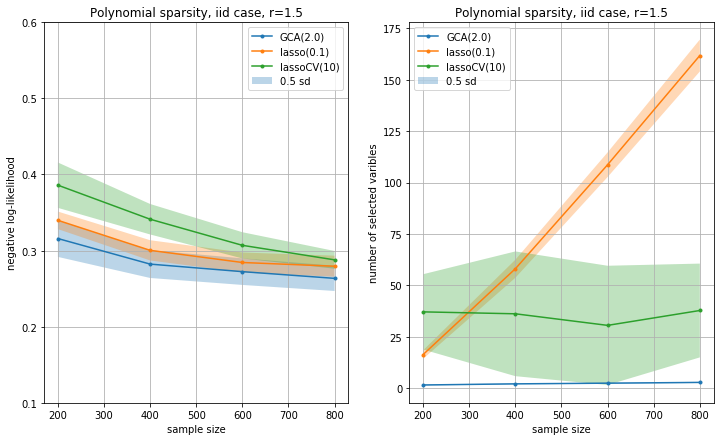

*iid exp ------------------------
 n:200 wn:2.0 C:0.1 b: 5.0 c: 2.0
 logLossCGA: 0.4337, std: 0.0489
 varNumCGA: 1.6400, std: 0.4937
 logLossLasso: 0.4442, std: 0.0267
 varNumLasso: 27.3833, std: 5.3469
 logLossLassoCV: 0.5238, std: 0.0939
 varNumLassoCV: 24.6667, std: 41.3072
 n:400 wn:2.0 C:0.1 b: 5.0 c: 2.0
 logLossCGA: 0.3984, std: 0.0314
 varNumCGA: 2.0633, std: 0.2569
 logLossLasso: 0.4209, std: 0.0282
 varNumLasso: 92.1967, std: 9.8521
 logLossLassoCV: 0.4349, std: 0.0391
 varNumLassoCV: 17.1933, std: 38.1777
 n:600 wn:2.0 C:0.1 b: 5.0 c: 2.0
 logLossCGA: 0.3936, std: 0.0320
 varNumCGA: 2.2567, std: 0.4368
 logLossLasso: 0.4246, std: 0.0343
 varNumLasso: 164.9333, std: 13.0694
 logLossLassoCV: 0.4092, std: 0.0261
 varNumLassoCV: 33.0700, std: 22.3239
 n:800 wn:2.0 C:0.1 b: 5.0 c: 2.0
 logLossCGA: 0.3911, std: 0.0354
 varNumCGA: 2.5833, std: 0.5063
 logLossLasso: 0.4334, std: 0.0364
 varNumLasso: 242.4633, std: 16.8988
 logLossLassoCV: 0.4052, std: 0.0304
 varNumLassoCV: 68.9467,

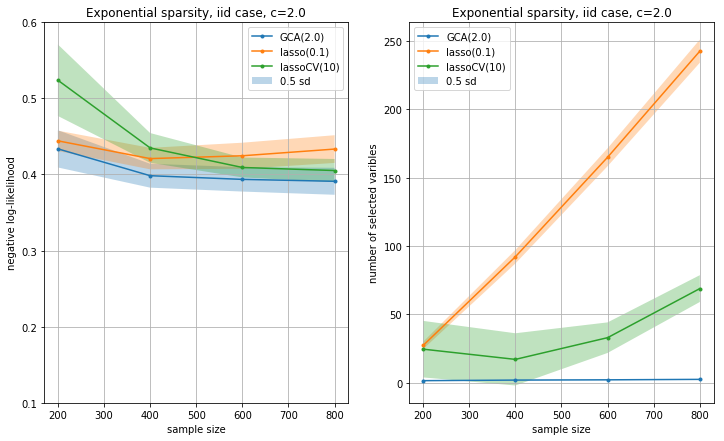

*iid str ------------------------
 n:200 beta: [3, 4, 3, 5]
 logLossCGA: 0.1790, std: 0.0376
 varNumCGA: 4.0000, std: 0.0816
 logLossLasso: 0.3214, std: 0.0191
 varNumLasso: 13.8233, std: 3.2922
 logLossLassoCV: 0.3183, std: 0.0829
 varNumLassoCV: 55.3033, std: 28.5020
 n:400 beta: [3, 4, 3, 5]
 logLossCGA: 0.1715, std: 0.0303
 varNumCGA: 4.0000, std: 0.0000
 logLossLasso: 0.2532, std: 0.0189
 varNumLasso: 44.7467, std: 7.6308
 logLossLassoCV: 0.3148, std: 0.0277
 varNumLassoCV: 14.6667, std: 32.9159
 n:600 beta: [3, 4, 3, 5]
 logLossCGA: 0.1685, std: 0.0284
 varNumCGA: 4.0000, std: 0.0000
 logLossLasso: 0.2289, std: 0.0183
 varNumLasso: 82.9533, std: 10.9175
 logLossLassoCV: 0.2700, std: 0.0167
 varNumLassoCV: 13.2133, std: 31.3327
 n:800 beta: [3, 4, 3, 5]
 logLossCGA: 0.1679, std: 0.0269
 varNumCGA: 4.0000, std: 0.0000
 logLossLasso: 0.2180, std: 0.0208
 varNumLasso: 126.8833, std: 13.4740
 logLossLassoCV: 0.2451, std: 0.0170
 varNumLassoCV: 18.4433, std: 28.2779
-------------------

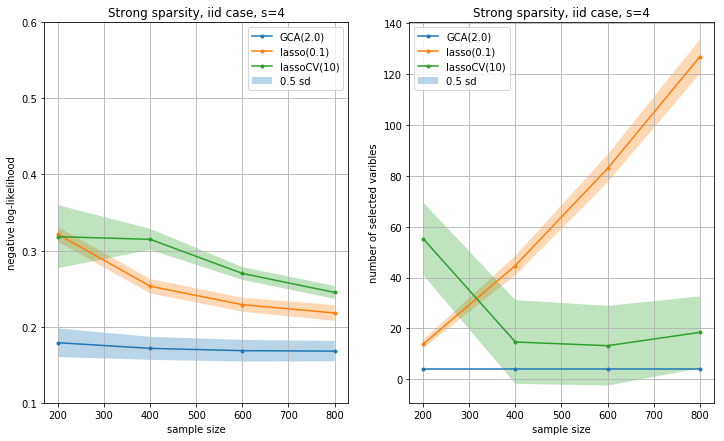

       sample size    200    400    600    800
iid       GCA(2.0)  0.316  0.282  0.272  0.264
pol     lasso(0.1)  0.340  0.300  0.284  0.279
r=1.5  lassoCV(10)  0.386  0.341  0.307  0.288
iid       GCA(2.0)  0.434  0.398  0.394  0.391
exp     lasso(0.1)  0.444  0.421  0.425  0.433
c=2.0  lassoCV(10)  0.524  0.435  0.409  0.405
iid       GCA(2.0)  0.179  0.172  0.169  0.168
str     lasso(0.1)  0.321  0.253  0.229  0.218
       lassoCV(10)  0.318  0.315  0.270  0.245


\begin{tabular}{llllll}
\toprule
{} &  sample size &    200 &    400 &    600 &    800 \\
\midrule
iid   &     GCA(2.0) &  0.316 &  0.282 &  0.272 &  0.264 \\
pol   &   lasso(0.1) &  0.340 &  0.300 &  0.284 &  0.279 \\
r=1.5 &  lassoCV(10) &  0.386 &  0.341 &  0.307 &  0.288 \\
iid   &     GCA(2.0) &  0.434 &  0.398 &  0.394 &  0.391 \\
exp   &   lasso(0.1) &  0.444 &  0.421 &  0.425 &  0.433 \\
c=2.0 &  lassoCV(10) &  0.524 &  0.435 &  0.409 &  0.405 \\
iid   &     GCA(2.0) &  0.179 &  0.172 &  0.169 &  0.168 \\
str   &  

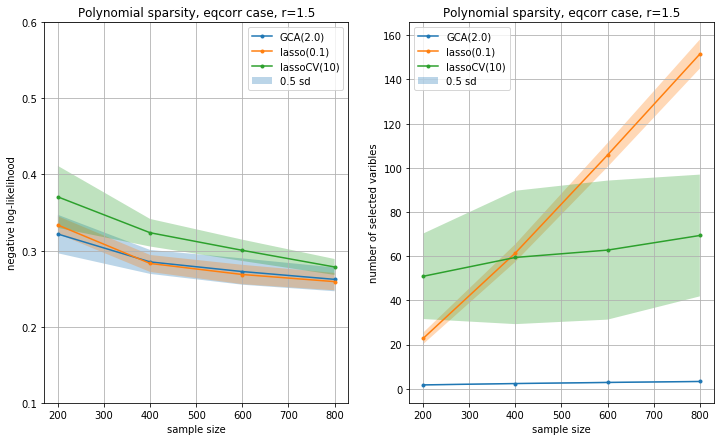

*eqcorr exp ------------------------
 n:200 wn:2.0 C:0.1 b: 5.0 c: 2.0
 logLossCGA: 0.4235, std: 0.0488
 varNumCGA: 1.6533, std: 0.4829
 logLossLasso: 0.4320, std: 0.0267
 varNumLasso: 27.7733, std: 5.4561
 logLossLassoCV: 0.5121, std: 0.0999
 varNumLassoCV: 26.1833, std: 42.9725
 n:400 wn:2.0 C:0.1 b: 5.0 c: 2.0
 logLossCGA: 0.3881, std: 0.0341
 varNumCGA: 2.1100, std: 0.3335
 logLossLasso: 0.4097, std: 0.0303
 varNumLasso: 88.2800, std: 9.8601
 logLossLassoCV: 0.4247, std: 0.0488
 varNumLassoCV: 20.4700, std: 36.8893
 n:600 wn:2.0 C:0.1 b: 5.0 c: 2.0
 logLossCGA: 0.3835, std: 0.0325
 varNumCGA: 2.3567, std: 0.4859
 logLossLasso: 0.4105, std: 0.0341
 varNumLasso: 158.0833, std: 13.8914
 logLossLassoCV: 0.3985, std: 0.0260
 varNumLassoCV: 37.1733, std: 34.4899
 n:800 wn:2.0 C:0.1 b: 5.0 c: 2.0
 logLossCGA: 0.3730, std: 0.0334
 varNumCGA: 2.6367, std: 0.4810
 logLossLasso: 0.4146, std: 0.0363
 varNumLasso: 234.1633, std: 16.8755
 logLossLassoCV: 0.3880, std: 0.0264
 varNumLassoCV: 67.32

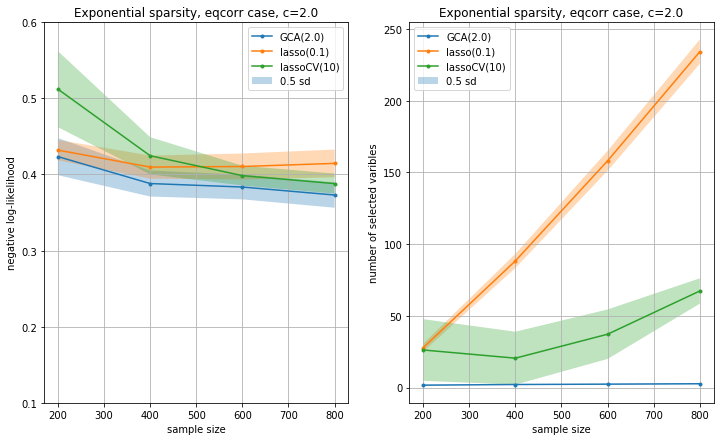

*eqcorr str ------------------------
 n:200 beta: [3, 4, 3, 5]
 logLossCGA: 0.1760, std: 0.0818
 varNumCGA: 3.9967, std: 0.1291
 logLossLasso: 0.3095, std: 0.0197
 varNumLasso: 15.0133, std: 4.0898
 logLossLassoCV: 0.3216, std: 0.0869
 varNumLassoCV: 46.9267, std: 30.1379
 n:400 beta: [3, 4, 3, 5]
 logLossCGA: 0.1590, std: 0.0287
 varNumCGA: 4.0000, std: 0.0000
 logLossLasso: 0.2407, std: 0.0173
 varNumLasso: 42.8067, std: 7.5062
 logLossLassoCV: 0.3006, std: 0.0292
 varNumLassoCV: 15.9833, std: 34.2019
 n:600 beta: [3, 4, 3, 5]
 logLossCGA: 0.1576, std: 0.0261
 varNumCGA: 4.0000, std: 0.0000
 logLossLasso: 0.2176, std: 0.0197
 varNumLasso: 78.4167, std: 10.4513
 logLossLassoCV: 0.2581, std: 0.0178
 varNumLassoCV: 15.5000, std: 30.9431
 n:800 beta: [3, 4, 3, 5]
 logLossCGA: 0.1566, std: 0.0279
 varNumCGA: 4.0000, std: 0.0000
 logLossLasso: 0.2063, std: 0.0206
 varNumLasso: 118.7633, std: 13.0617
 logLossLassoCV: 0.2338, std: 0.0172
 varNumLassoCV: 18.7367, std: 19.3955
----------------

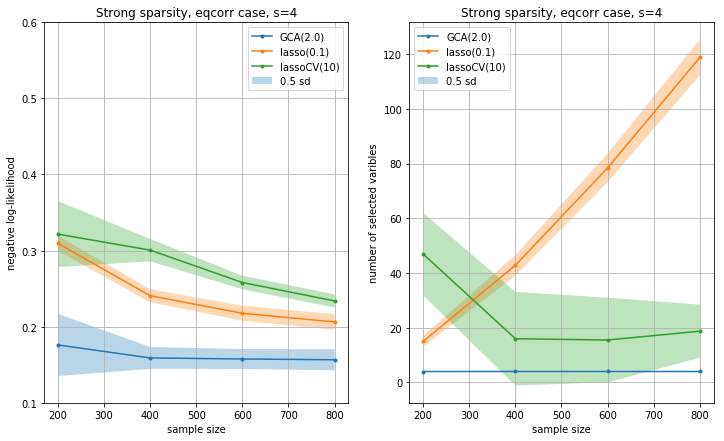

          sample size    200    400    600    800
eqcorr       GCA(2.0)  0.322  0.285  0.272  0.262
pol        lasso(0.1)  0.334  0.283  0.269  0.259
r=1.5     lassoCV(10)  0.371  0.323  0.300  0.278
eqcorr       GCA(2.0)  0.423  0.388  0.384  0.373
exp        lasso(0.1)  0.432  0.410  0.410  0.415
c=2.0     lassoCV(10)  0.512  0.425  0.398  0.388
eqcorr       GCA(2.0)  0.176  0.159  0.158  0.157
str        lasso(0.1)  0.309  0.241  0.218  0.206
          lassoCV(10)  0.322  0.301  0.258  0.234


\begin{tabular}{llllll}
\toprule
{} &  sample size &    200 &    400 &    600 &    800 \\
\midrule
eqcorr   &     GCA(2.0) &  0.322 &  0.285 &  0.272 &  0.262 \\
pol      &   lasso(0.1) &  0.334 &  0.283 &  0.269 &  0.259 \\
r=1.5    &  lassoCV(10) &  0.371 &  0.323 &  0.300 &  0.278 \\
eqcorr   &     GCA(2.0) &  0.423 &  0.388 &  0.384 &  0.373 \\
exp      &   lasso(0.1) &  0.432 &  0.410 &  0.410 &  0.415 \\
c=2.0    &  lassoCV(10) &  0.512 &  0.425 &  0.398 &  0.388 \\
eqcorr   &     GCA(2.

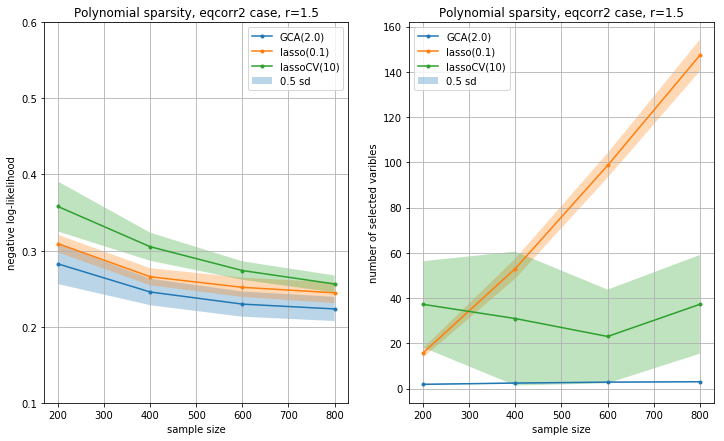

*eqcorr2 exp ------------------------
 n:200 wn:2.0 C:0.1 b: 5.0 c: 2.0
 logLossCGA: 0.3997, std: 0.0516
 varNumCGA: 1.6967, std: 0.4597
 logLossLasso: 0.4079, std: 0.0250
 varNumLasso: 26.3167, std: 5.4396
 logLossLassoCV: 0.4780, std: 0.0761
 varNumLassoCV: 20.7700, std: 35.8668
 n:400 wn:2.0 C:0.1 b: 5.0 c: 2.0
 logLossCGA: 0.3686, std: 0.0351
 varNumCGA: 2.1433, std: 0.3598
 logLossLasso: 0.3903, std: 0.0288
 varNumLasso: 85.6967, std: 9.5480
 logLossLassoCV: 0.4030, std: 0.0441
 varNumLassoCV: 17.2367, std: 36.5919
 n:600 wn:2.0 C:0.1 b: 5.0 c: 2.0
 logLossCGA: 0.3629, std: 0.0346
 varNumCGA: 2.3833, std: 0.4862
 logLossLasso: 0.3900, std: 0.0349
 varNumLasso: 155.1633, std: 14.1994
 logLossLassoCV: 0.3784, std: 0.0255
 varNumLassoCV: 34.2600, std: 26.6797
 n:800 wn:2.0 C:0.1 b: 5.0 c: 2.0
 logLossCGA: 0.3605, std: 0.0340
 varNumCGA: 2.5967, std: 0.4906
 logLossLasso: 0.4015, std: 0.0359
 varNumLasso: 227.1100, std: 16.3957
 logLossLassoCV: 0.3764, std: 0.0348
 varNumLassoCV: 70.1

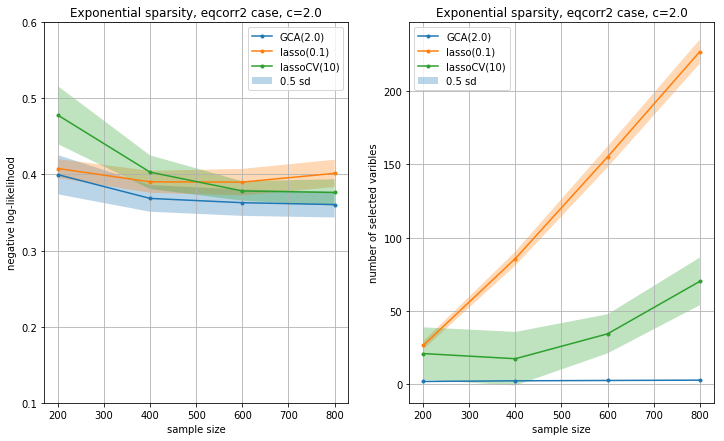

*eqcorr2 str ------------------------
 n:200 beta: [3, 4, 3, 5]
 logLossCGA: 0.1684, std: 0.1090
 varNumCGA: 4.0100, std: 0.0995
 logLossLasso: 0.2975, std: 0.0178
 varNumLasso: 14.2167, std: 3.5669
 logLossLassoCV: 0.3495, std: 0.0899
 varNumLassoCV: 32.6000, std: 33.1063
 n:400 beta: [3, 4, 3, 5]
 logLossCGA: 0.1537, std: 0.0273
 varNumCGA: 4.0000, std: 0.0000
 logLossLasso: 0.2338, std: 0.0175
 varNumLasso: 43.6800, std: 7.1127
 logLossLassoCV: 0.2921, std: 0.0244
 varNumLassoCV: 11.8600, std: 26.6371
 n:600 beta: [3, 4, 3, 5]
 logLossCGA: 0.1503, std: 0.0268
 varNumCGA: 4.0000, std: 0.0000
 logLossLasso: 0.2097, std: 0.0186
 varNumLasso: 80.0867, std: 10.8040
 logLossLassoCV: 0.2490, std: 0.0159
 varNumLassoCV: 10.9133, std: 19.7388
 n:800 beta: [3, 4, 3, 5]
 logLossCGA: 0.1502, std: 0.0258
 varNumCGA: 4.0000, std: 0.0000
 logLossLasso: 0.1995, std: 0.0191
 varNumLasso: 118.6700, std: 12.2273
 logLossLassoCV: 0.2260, std: 0.0154
 varNumLassoCV: 18.6033, std: 21.0865
---------------

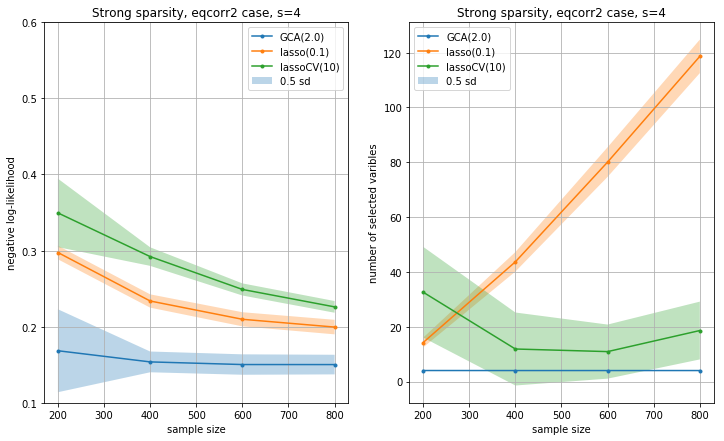

           sample size    200    400    600    800
eqcorr2       GCA(2.0)  0.283  0.246  0.230  0.223
pol         lasso(0.1)  0.309  0.266  0.252  0.245
r=1.5      lassoCV(10)  0.358  0.305  0.274  0.256
eqcorr2       GCA(2.0)  0.400  0.369  0.363  0.360
exp         lasso(0.1)  0.408  0.390  0.390  0.401
c=2.0      lassoCV(10)  0.478  0.403  0.378  0.376
eqcorr2       GCA(2.0)  0.168  0.154  0.150  0.150
str         lasso(0.1)  0.297  0.234  0.210  0.200
           lassoCV(10)  0.350  0.292  0.249  0.226


\begin{tabular}{llllll}
\toprule
{} &  sample size &    200 &    400 &    600 &    800 \\
\midrule
eqcorr2   &     GCA(2.0) &  0.283 &  0.246 &  0.230 &  0.223 \\
pol       &   lasso(0.1) &  0.309 &  0.266 &  0.252 &  0.245 \\
r=1.5     &  lassoCV(10) &  0.358 &  0.305 &  0.274 &  0.256 \\
eqcorr2   &     GCA(2.0) &  0.400 &  0.369 &  0.363 &  0.360 \\
exp       &   lasso(0.1) &  0.408 &  0.390 &  0.390 &  0.401 \\
c=2.0     &  lassoCV(10) &  0.478 &  0.403 &  0.378 &  0.376 \\
eqcor

In [10]:
# res[(dependence, sparsity, n, n_test, m, *list(parameters.values()))]
dependence = ['iid', 'eqcorr', 'eqcorr2']
sparsity = ['pol', 'exp', 'str']
ns = [200, 400, 600, 800]
n_test = 300
m = 300
# beta = [3, 4, 3, 5]
parameters = {'wn':2.0, 'C':0.1, 'cv':10 , 'b':5.0, 'r':1.5, 'c':2.0, 'eta':0.2, 
              's':4, 'beta0':3, 'beta1':4, 'beta2':3, 'beta3':5}
for d in dependence:
    dataloss, dataVar = {}, {}
    for s in sparsity:
        print('*'+d+' '+s+' '+'------------------------')
        for n in ns:
            res[(d, s, n, n_test, m, *list(parameters.values()))] = simulation(n, n_test, 5*n, m, d, s, parameters)
        print('---------------------------------')
        plogfig(d, s, parameters, savefig=True)
    
    df = pd.DataFrame(dataloss, index=['sample size', 200, 400, 600, 800], dtype=float)
    df.T.iloc[:,1:] = df.T.iloc[:,1:].replace('\$\s+','', regex=True).astype(float).applymap('{:,.3f}'.format)
    print(df.T)
    print('\n')
    print(df.T.to_latex())

    df = pd.DataFrame(dataVar, index=['\# of variables', 200, 400, 600, 800], dtype=float)
    df.T.iloc[:,1:] = df.T.iloc[:,1:].replace('\$\s+','', regex=True).astype(float).applymap('{:,.3f}'.format)
    print(df.T)
    print('\n')
    print(df.T.to_latex())